In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from cwgp.cwgp import CWGP
from cwgp.kernel import RBF
import GPy
import numpy as np

In [2]:
CSV_FIlE = "japan3.csv"
df = pd.read_csv(CSV_FIlE)
df_50 = df[(df["age"]==50)]

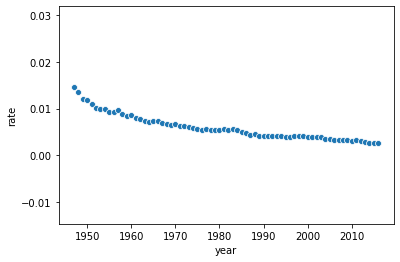

In [3]:
sns.scatterplot(df_50["year"],df_50["rate"])

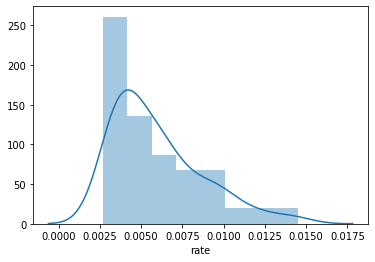

In [4]:
sns.distplot(df_50["rate"])

In [5]:
rate = df_50["rate"].to_numpy().reshape(-1,1)
year = df_50["year"].to_numpy().reshape(-1,1)

In [64]:
sa_1 = CWGP("sal",n=3)
sal_1 = CWGP("sa",n=5)

[ 0.40076063  3.08581065  4.9765249  -0.31617272  1.06967968  1.57304735
  2.94597984  0.3847653   3.53895868  0.44840318  3.75162247  0.31348773]


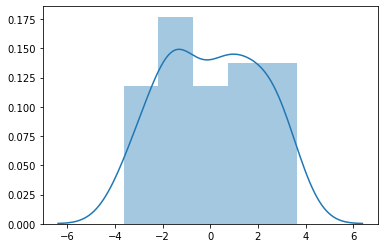

In [65]:
p_1 = sa_1.fit(rate).x
print(p_1)
x_1, d = sa_1.phi.comp_phi(p_1,rate)
sns.distplot(x_1)

[ 1.38585208  0.71185264  1.04942334 -0.0744722   1.27094414  0.08746819
  0.67381486 -0.23969131  0.80230103 -0.30770513]


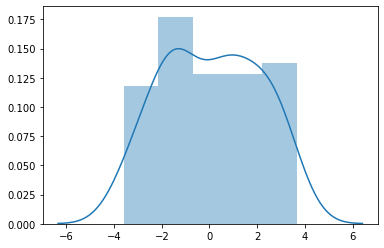

In [67]:
p_2 = sal_1.fit(x_1).x
print(p_2)
x_2, d = sal_1.phi.comp_phi(p_2,x_1)
sns.distplot(x_2)


Name : GP regression
Objective : -9.303118433595095
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.             |                   value  |  constraints  |  priors
  sum.mul.rbf.variance       |       2.385482840566849  |      +ve      |        
  sum.mul.rbf.lengthscale    |       65901.05215647229  |      +ve      |        
  sum.mul.Mat32.variance     |       2.385482569120464  |      +ve      |        
  sum.mul.Mat32.lengthscale  |       27.31601915274847  |      +ve      |        
  sum.bias.variance          |  5.562684646268137e-309  |      +ve      |        
  Gaussian_noise.variance    |    0.012560699945248976  |      +ve      |        


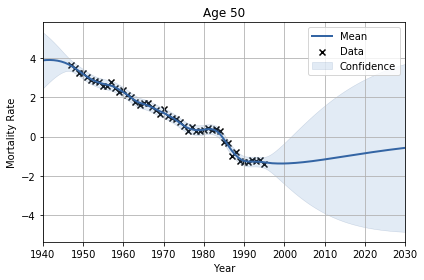

In [68]:
kernel = GPy.kern.RBF(1)*GPy.kern.Matern32(1) + GPy.kern.Bias(1)

ratio = 0.7
length = len(df_50)
train = int(ratio*length)

model_cwgp = GPy.models.GPRegression(df_50.year[:, None][:train], x_2[:train], kernel=kernel)
model_cwgp.optimize()
print(model_cwgp)
model_cwgp.plot(plot_limits=[1940,2030])

plt.title('Age ' + str(50))
plt.xlabel('Year')
plt.ylabel('Mortality Rate')

plt.grid(True)
plt.show()

In [69]:
data = []
for i in range(1940,2031):
    data.append(model_cwgp.predict(np.array(i).reshape(1,-1)))
tr_data = np.array(data).reshape(-1,1,2)
tr_data

array([[[ 3.89562501,  0.52952731]],

       [[ 3.91107994,  0.3983728 ]],

       [[ 3.9118648 ,  0.28522092]],

       [[ 3.89599271,  0.19177914]],

       [[ 3.86127953,  0.11913602]],

       [[ 3.80532656,  0.067461  ]],

       [[ 3.72550178,  0.03562064]],

       [[ 3.6189196 ,  0.0206922 ]],

       [[ 3.48541022,  0.01673304]],

       [[ 3.33813642,  0.0163058 ]],

       [[ 3.19410935,  0.01630572]],

       [[ 3.0538547 ,  0.01626098]],

       [[ 2.9284865 ,  0.01622326]],

       [[ 2.82964644,  0.01620997]],

       [[ 2.75367285,  0.01620776]],

       [[ 2.69321766,  0.01620769]],

       [[ 2.64989852,  0.01620764]],

       [[ 2.59975409,  0.01620756]],

       [[ 2.51016028,  0.01620752]],

       [[ 2.39605383,  0.01620751]],

       [[ 2.27242162,  0.01620751]],

       [[ 2.12745305,  0.01620751]],

       [[ 1.97506314,  0.01620751]],

       [[ 1.83491198,  0.01620751]],

       [[ 1.73271773,  0.01620751]],

       [[ 1.66631912,  0.01620751]],

       [[ 1.

In [70]:
CI = 1.96
mean = tr_data[:,:,0]
var_upper = mean + CI*tr_data[:,:,1]
var_lower = mean - CI*tr_data[:,:,1]
predict_mean = sal_1.phi.inv_comp_phi(p_2,mean)
predict_mean = sa_1.phi.inv_comp_phi(p_1,predict_mean)
predict_var_upper = sal_1.phi.inv_comp_phi(p_2,var_upper)
predict_var_upper = sa_1.phi.inv_comp_phi(p_1,predict_var_upper)
predict_var_lower = sal_1.phi.inv_comp_phi(p_2,var_lower)
predict_var_lower = sa_1.phi.inv_comp_phi(p_1,predict_var_lower)

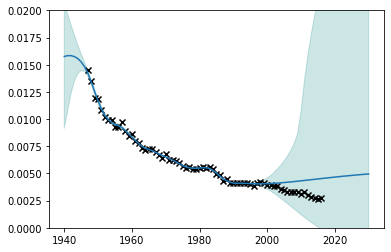

In [22]:
plt.fill_between(np.linspace(1940,2030,91),np.ravel(predict_var_upper),np.ravel(predict_var_lower),color=(0,0.5,0.5,0.2))
plt.scatter(year, rate, marker="x", color='black')
plt.ylim([0,0.02])
plt.plot(np.linspace(1940,2030,91),predict_mean)
